In [ ]:
# !pip install numpy
# !pip install scikit-learn
# !pip install matplotlib

In [78]:
import numpy as np
import abc
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
%matplotlib inline

# Übung 8: Agglomerative Hierarchical Clustering

Implementieren Sie die untenstehenden _Linkage Funktionen_: `SingleLinkage`, `CompleteLinkage`, `AverageLinkage` und `CentroidLinkage` (je 1,25 Punkte) für den _Agglomerative Hierarchical Clustering_ Algorithmus. Dieser ist bereits für Sie implementiert.

### Distanz-Funktionen

In [29]:
class DistFunc(metaclass=abc.ABCMeta):
    """abstract class for computing the distance between 2 vectors"""

    @abc.abstractmethod
    def __call__(self, a, b):
        """
        Args:
            a (numpy.ndarray): vector a (1D)
            b (numpy.ndarray): vector b (1D)
            
        Returns:
            float: distance between vector a and vector b
        """
        raise NotImplementedError()

class EuclideanDistance(DistFunc):
    """compute the euclidean distance between 2 vectors"""

    def __call__(self, a, b):
        return np.linalg.norm(a - b)

### Linkage-Funktionen

In [89]:
class Linkage(metaclass=abc.ABCMeta):
    """abstract class for computing the linkage between 2 clusters"""
    
    def __call__(self, cluster_a, cluster_b, dist_func):
        """
        Args:
            cluster_a (numpy.ndarray): 2D data matrix for members of cluster a (columns->features, rows->samples)
            cluster_b (numpy.ndarray): 2D data matrix for members of cluster b (columns->features, rows->samples)
            dist_func (DistFunc): distance function for 2 vectors

        Returns:
            float: the computed linkage
        """
        raise NotImplementedError()

class SingleLinkage(Linkage):
    """computes the Single Linkage between two clusters"""
    
    def __call__(self, cluster_a, cluster_b, dist_func):
        return np.min([dist_func(a, b) for a in cluster_a for b in cluster_b])
    
    def __str__(self):
        return "Single Linkage"

class CompleteLinkage(Linkage):
    """computes the Complete Linkage between two clusters"""
    
    def __call__(self, cluster_a, cluster_b, dist_func):
        return np.max([dist_func(a, b) for a in cluster_a for b in cluster_b])
    
    def __str__(self):
        return "Complete Linkage"
    
class AverageLinkage(Linkage):
    """computes the Average Linkage between two clusters"""
    
    def __call__(self, cluster_a, cluster_b, dist_func):
        return np.mean([dist_func(a, b) for a in cluster_a for b in cluster_b])
    
    def __str__(self):
        return "Average Linkage"
    
class CentroidLinkage(Linkage):
    """computes the Centroid Linkage between two clusters"""
    
    def __call__(self, cluster_a, cluster_b, dist_func):
        return dist_func(np.mean(cluster_a, axis=0), np.mean(cluster_b, axis=0))
    
    def __str__(self):
        return "Centroid Linkage"

### Clustering Algorithmus

In [90]:
class AgglomerativeHierarchicalClustering:
    """
    implementation of the hierarchical clustering algorithm with variable distance function
    and linkage function.
    
    implementation is not optimized and therefore slow.

    Attributes:
        dist_func (DistFunc): distance function
        linkage (Linkage): linkage function
        clusters (dict): dictionary describing the clusters,
            with Cluster-IDs as keys and list of data indices as values
    """
    
    def __init__(self, dist_func, linkage):
        self.dist_func = dist_func
        self.linkage = linkage
        self.clusters = None 

    def fit(self, X, n_clusters=2):
        """
        perform the clustering on the given data and obtain the given number of clusters.
        store clustering results in ``self.clusters``
        
        Args:
            X (numpy.ndarray): 2D data matrix (columns->features, rows->samples)
            n_clusters (int): number of clusters to obtain
        
        Returns:
            None
        """
        self._init_clusters(X)
        while len(self.clusters.keys()) > n_clusters:
            cluster_a, cluster_b = self._find_closest_clusters(X)
            self._merge_clusters(cluster_a, cluster_b)
            
    def fit_predict(self, X, n_clusters=2):
        """
        perform the clustering on the given data and obtain the given number of clusters
        and return the predicted Cluster-IDs
        
        Args:
            X (numpy.ndarray): 2D data matrix (columns->features, rows->samples)
            n_clusters (int): number of clusters to obtain
        
        Returns:
            numpy.ndarray: vector (1 col, X rows) of predicted Cluster-IDs (starting from 0)
        """
        self.fit(X, n_clusters=n_clusters)
        predictions = []
        for cluster_id, members in self.clusters.items():
            for member in members:
                predictions.append((member, cluster_id))
        predictions.sort(key=lambda x: x[0])
        return np.array(predictions)[:, 1:]
            
    def _init_clusters(self, X):
        self.clusters = {i: [i] for i in range(len(X))}
            
    def _merge_clusters(self, cluster_a, cluster_b):
        new_clusters = {0: self.clusters[cluster_a] + self.clusters[cluster_b]}
        i = 1
        for cluster_id in self.clusters.keys():
            if not cluster_id in [cluster_a, cluster_b]:
                new_clusters[i] = self.clusters[cluster_id]
                i += 1
        self.clusters = new_clusters

    def _find_closest_clusters(self, X):
        min_dist = np.inf
        closest_clusters = None
        clusters_ids = list(self.clusters.keys())
        for i, cluster_i in enumerate(clusters_ids[:-1]):
            for cluster_j in clusters_ids[i+1:]:
                dist = self.linkage(X[self.clusters[cluster_i]], X[self.clusters[cluster_j]], self.dist_func)
                if dist < min_dist:
                    min_dist, closest_clusters = dist, (cluster_i, cluster_j)
        return closest_clusters

## Überprüfung

Mit dem folgenden Code können Sie Ihre Implementierung testen. In dem Code wird der Iris-Flower Datensatz (siehe Übung 4) geladen. Wir trainieren ein `AgglomerativeHierarchicalClustering`-objekt auf den Features und vergleichen die durch Clustering erhaltenen Labels mit den echten Labels. Probieren Sie verschiedene Werte für `LINKAGE` und `N_CLUSTERS` aus.

/tmp/ipykernel_108368/3187039652.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


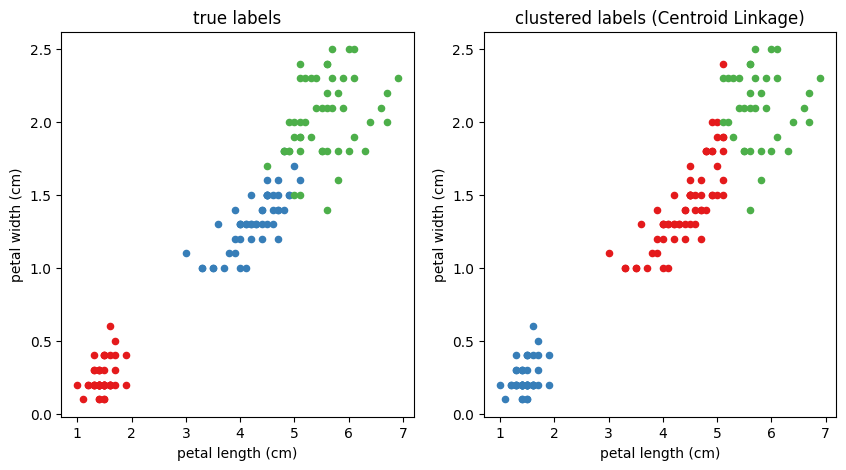

In [88]:
LINKAGE = CentroidLinkage()
N_CLUSTERS = 3

# load iris data
iris_data = load_iris(as_frame=True)
df = iris_data['frame']

# perform clustering
model = AgglomerativeHierarchicalClustering(
    dist_func=EuclideanDistance(),
    linkage=LINKAGE,
)
df['prediction'] = model.fit_predict(iris_data['data'].values, n_clusters=N_CLUSTERS)

# plot clusters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
colors = plt.cm.Set1.colors
for label, group in df.groupby('target'):
    group.plot(ax=ax1, kind='scatter', x='petal length (cm)', y='petal width (cm)', color=colors[label])
for label, group in df.groupby('prediction'):
    group.plot(ax=ax2, kind='scatter', x='petal length (cm)', y='petal width (cm)', color=colors[label])
ax1.set_title('true labels')
ax2.set_title(f'clustered labels ({LINKAGE})')
fig.show()